In [1]:
#Authors: Adam Lewandowski, Ivan Sladkov, Patrick English
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import nltk
from sklearn.utils import shuffle
import matplotlib
import matplotlib.pyplot as plt
# random seeds
seed=2020
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
def str_list_to_list(tweets):
    t = tweets.copy()
    import ast 
    t["tweets"] = t["tweets"].apply(lambda x: ast.literal_eval(x))
    return t
#Download this: https://drive.google.com/open?id=1-3lesjyVd1gGnjJGz_cipqO8CNeiTiPx
#Put it into data folder
tweets = pd.read_csv("data/processed_tweets.csv", encoding = "ISO-8859-1")
tweets = str_list_to_list(tweets)

## Data Pre-processing For Deep Neural Networks
Right now, the data and targets are conained in a pandas dataframe.
In order to train a keras model, we need to convert the tweets into a list of integers representing all the words and convert the sentiment targets into binary values.
### Tweets
First we need to create a dictionary of the words we will use to train our model with.
First we will count each word in the whole dataset and create a frequency distribution of all values. We will use this to pick a subset of the most frequent words. While doing this, all twitter user handles will be replaced by the "usr" tag. Each word will be assigned an integer value according to their index in the dictionary. We can use this to transform each tweet into an input for our models. The unknown words will be replaced by an "unk" tag and the sentences will be padded to the same size using the "pad" tag.
### Sentiment Targets
The targets in the dataset are either 0 for negative sentences or 4 for positive sentences. To be able to make a Neural Network using binary values, we replaced all positive sentences with a value of 1.

In [3]:
def parse_tweet(tweet, word_dictionary):
    sentence = []
    for word in tweet:
        try:
            if word[0]=='@':
                sentence.append(word_dictionary['<usr>'])
            else:
                sentence.append(word_dictionary[word])
        except KeyError:
            sentence.append(1)
    return sentence

In [18]:
def prepare_input_data(df, dictionary_size):
    # Pre-processing for word embeddings
    # Count each unique word
    raw_words = df['tweets']
    word_count = {}
    for tweet in raw_words:
        for word in tweet:
            if word[0]!='@' and not any(c in word for c in ['.', ',']):
                if word in word_count:
                    word_count[word] += 1
                else:
                    word_count[word] = 1
    # Sort each unique word using the value
    sorted_word_count = sorted(word_count.items(), key=lambda key: key[1], reverse=True)
    
    # create dictionaries to convert tokens to integers and integers to tokens (needed for the embedding layer)
    # <pad> will be used for padding the data because the NN inputs have to be the same size and tweets are of varying length
    # <unk> will be used to replace tokens that were too uncommon to add to the dictionary
    word_dictionary={'<pad>': 0, '<unk>': 1, '<usr>': 2}
    for i in range(dictionary_size):
        word_dictionary[sorted_word_count[i][0]]=i+3
    reverse_dictionary = dict([(value, key) for (key, value) in word_dictionary.items()])

    # Convert each token into its index in the dictionary and
    # create a new dataframe with the list of indexes and corresponding targets
    data=[]
    
    for tweet in df['tweets']:
        data.append(parse_tweet(tweet, word_dictionary))

    input_data=pd.DataFrame({
        'data': data,
        'targets': df['target']
    })
    
    return input_data, word_dictionary, reverse_dictionary, word_count, sorted_word_count

In [5]:
def split_padded_data(data, seed, tweet_length=None, sample_size=None):
    if tweet_length == None:
        # Get the length of the longest tweet
        max_tweet_length=len(max(data['data'], key=len))
    else:
        max_tweet_length=tweet_length
    # Split the data 80% train data (later a subset will be selected as validation data) - 20% test data
    shuffled_dataframe=shuffle(data, random_state=seed)
    if sample_size != None:
        shuffled_dataframe=shuffled_dataframe[:sample_size]
    train_dataframe=shuffled_dataframe.sample(frac=0.8, random_state=seed)
    test_dataframe=shuffled_dataframe.drop(train_dataframe.index)
    
    # Pad the tweets with <pad> up to the max tweet length so all tweets have the same length
    train_data=keras.preprocessing.sequence.pad_sequences(list(train_dataframe['data']),
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_tweet_length)
    train_targets=train_dataframe['targets'].replace(4,1)
    
    test_data=keras.preprocessing.sequence.pad_sequences(list(test_dataframe['data']),
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_tweet_length)
    test_targets=test_dataframe['targets'].replace(4,1)
    
    return train_data, train_targets, test_data, test_targets, max_tweet_length
    

## Creating the Model
We experimented using two different models: a CNN and an LSTM model. We trained each model using the same data and tried using pre-trained and self-trained Embedding layers
### LSTM
The LSTM model consists of:
    1. An embedding layer
    2. A bidirectional LSTM
    3. A dense layer
A dropout of 20% is applied to the data before and after the LSTM layer

### CNN
The convolutional neural network consists of:
    1. An embedding layer
    2. A 1-dimensional convolution layer
    3. A 1-dimensional Max Pooling layer
    4. A Flatten layer
    5. A dense layer
A dropout of 20% is applied to the data after the embedding layer and before the dense layer

In [6]:
def create_LSTM_model(train_data, train_targets, word_dictionary, max_tweet_length, seed, pretrained_embeddings=False, train_embeddings=True):
    model = keras.models.Sequential()
    #load pre-trained glove models or train own models
    if pretrained_embeddings:
        embeddings = {}
        with open('data/glove.6B.100d.txt', encoding='utf-8') as file:
            for line in file:
                values = line.split()
                word = values[0]
                vectors = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vectors
        embedding_weights = np.zeros((len(word_dictionary), 100))
        for word, i in list(word_dictionary.items()):
            vector = embeddings.get(word)
            if vector is not None:
                embedding_weights[i] = vector
        print('embeddings loaded')
        model.add(keras.layers.Embedding(len(word_dictionary), output_dim=100, input_length=max_tweet_length, trainable=train_embeddings, weights=[embedding_weights]))
    else:
        model.add(keras.layers.Embedding(len(word_dictionary), output_dim=150, input_length=max_tweet_length, trainable=True, embeddings_initializer=keras.initializers.RandomUniform(seed=None)))
    
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(80, kernel_initializer=keras.initializers.glorot_uniform(seed=seed),recurrent_initializer=keras.initializers.orthogonal(seed=seed))))
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [51]:
def create_CNN_model(train_data, train_targets, word_dictionary, max_tweet_length, seed, pretrained_embeddings=False, train_embeddings=True):
    model = keras.models.Sequential()
    #load pre-trained glove models or train own models
    if pretrained_embeddings:
        embeddings = {}
        with open('data/glove.6B.100d.txt', encoding='utf-8') as file:
            for line in file:
                values = line.split()
                word = values[0]
                vectors = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vectors
        embedding_weights = np.zeros((len(word_dictionary), 100))
        for word, i in list(word_dictionary.items()):
            vector = embeddings.get(word)
            if vector is not None:
                embedding_weights[i] = vector
        print('embeddings loaded')
        model.add(keras.layers.Embedding(len(word_dictionary), output_dim=100, input_length=max_tweet_length, trainable=train_embeddings, weights=[embedding_weights]))
    else:
        model.add(keras.layers.Embedding(len(word_dictionary), output_dim=300, input_length=max_tweet_length, trainable=True, embeddings_initializer=keras.initializers.RandomUniform(seed=None)))
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.Conv1D(300, 3, kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
    model.add(keras.layers.MaxPool1D(2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.Dense(150, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

## Training the Model
We trained the model using a dictionary size of 25000. After pre-processing the data and creating the model, we train it using a batch size of 20 in order to make it a bit faster without losing too much in accuracy. The train data is split into 90% train and 10% validation. The model is trained for 2 epochs, because after three epochs, the model starts to overfit on the data.

In [27]:
# Some variables used for pre-processing the data
dictionary_size=10000

In [28]:
# Pre-process the data.
# Create the dictionaries
input_data, word_dictionary, reverse_dictionary, word_count, sorted_word_count = prepare_input_data(tweets, dictionary_size)

In [32]:
sorted_word_count[10000]

('plum', 58)

In [30]:
#split and pad the data
train_data, train_targets, test_data, test_targets, max_tweet_length = split_padded_data(input_data, seed, 25)

In [31]:
rnn_model=create_LSTM_model(train_data, train_targets, word_dictionary, max_tweet_length, seed)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 150)           1500450   
_________________________________________________________________
dropout_3 (Dropout)          (None, 26, 150)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160)               147840    
_________________________________________________________________
dropout_4 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 1,648,451
Trainable params: 1,648,451
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
rnn_model.fit(train_data, train_targets, epochs=5,batch_size=50, verbose=1, validation_split=0.1)

In [ ]:
rnn_model.evaluate(test_data, test_targets, batch_size=50)

In [54]:
cnn_model=create_CNN_model(train_data, train_targets, word_dictionary, max_tweet_length, seed)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 26, 300)           3000900   
_________________________________________________________________
dropout_18 (Dropout)         (None, 26, 300)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24, 300)           270300    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 12, 300)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 3600)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)               

In [55]:
cnn_model.fit(train_data, train_targets, epochs=4,batch_size=100, verbose=1, validation_split=0.1)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/4
1152000/1152000 [==============================] - 834s 724us/sample - loss: 0.5801 - accuracy: 0.7052 - val_loss: 0.5254 - val_accuracy: 0.7680
Epoch 2/4
1152000/1152000 [==============================] - 800s 694us/sample - loss: 0.5651 - accuracy: 0.7190 - val_loss: 0.5299 - val_accuracy: 0.7634
Epoch 3/4
 763100/1152000 [==================>...........] - ETA: 4:10 - loss: 0.5593 - accuracy: 0.7253

KeyboardInterrupt: 

In [ ]:
cnn_model.evaluate(test_data, test_targets, batch_size=50)

### Here is some extra data analysis we used
We plotted the distribution of tweet lengths and found out that most of the tweets are between the 2 and 20 tokens long. We used this to choose the maximum input length of a tweet.

In [121]:
lengths = [len(x) for x in input_data['data']]

In [122]:
unique_lengths = set(lengths)

In [123]:
length_occurrence = []
for i in unique_lengths:
    length_occurrence.append(lengths.count(i))

In [124]:
plt.rcParams['figure.figsize'] = [10, 5]

<BarContainer object of 40 artists>

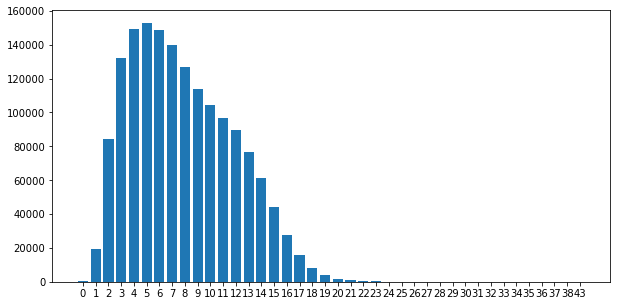

In [125]:
plt.bar([str(i) for i in unique_lengths], length_occurrence)

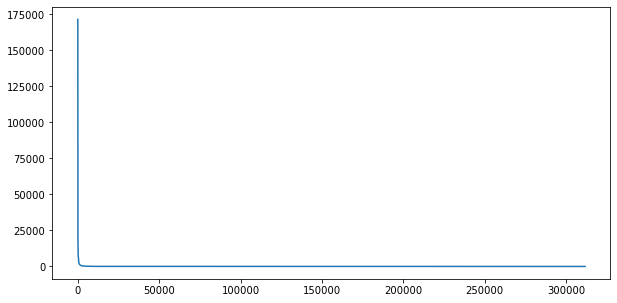

In [126]:
plt.plot([x[1] for x in sorted_word_count])

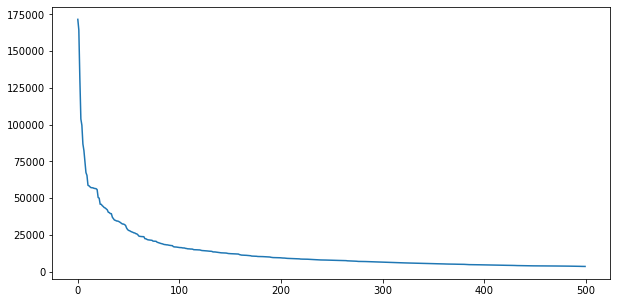

In [134]:
plt.plot([x[1] for x in sorted_word_count[:500]])

In [119]:
sorted_word_count[20000]

('rodent', 19)

In [79]:
len(sorted_word_count)

311787